# A wide variety of models for multi-class classification

X features= ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
(20640, 10) (13828, 10) (6812, 10)


<AxesSubplot:>

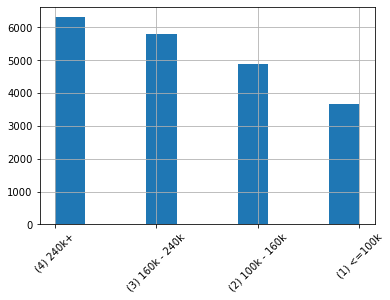

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
cal_housing = fetch_california_housing()
X = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
y = cal_housing.target
df = X.copy()
df['y'] = y * 100000 # The raw value is in 100,000.
X_features = cal_housing.feature_names
print("X features=", X_features)

# Make the multi-class target
def val_y(y):
    if y<=100000:
        return '(1) <=100k'
    elif y<=160000:
        return '(2) 100k - 160k'
    elif y<=240000:
        return '(3) 160k - 240k'
    else:
        return '(4) 240k+'
    
df['y_class'] = df['y'].apply(val_y)

train, test = train_test_split(df, test_size=0.33, random_state=42)
print(df.shape, train.shape, test.shape)

df['y_class'].hist(xrot=45)

## (1) Multi-class Logistic Classification
* Logistic Regression: [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
* Logistic Regression with Cross Validation: [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

In [2]:
from sklearn.linear_model import LogisticRegression

#modeling
LM_model = LogisticRegression(penalty='l2', max_iter=500, multi_class='ovr', solver='liblinear')
LM_model.fit(train[X_features],train['y_class'])

# Prediction
LM_pred_prob = pd.DataFrame(LM_model.predict_proba(test[X_features]))
LM_pred = pd.DataFrame(LM_model.predict(test[X_features]))
LM_pred = pd.concat([test.reset_index()['y_class'],LM_pred_prob,LM_pred],axis=1, ignore_index=True)
print(LM_pred.shape)

LM_pred.columns = ['Actual','Y_prob (1) <=100k', 'Y_prob (2) 100k - 160k','Y_prob (3) 160k - 240k', 'Y_prob (4) 240k+', 'Y_pred']
LM_pred.head()

(6812, 6)


,Actual,Y_prob (1) <=100k,Y_prob (2) 100k - 160k,Y_prob (3) 160k - 240k,Y_prob (4) 240k+,Y_pred
0,(1) <=100k,0.453130,0.331161,0.206053,0.009656,(1) <=100k
1,(1) <=100k,0.238225,0.342282,0.328045,0.091448,(2) 100k - 160k
2,(4) 240k+,0.067076,0.108626,0.190556,0.633742,(4) 240k+
3,(3) 160k - 240k,0.003863,0.130184,0.320634,0.545318,(4) 240k+
4,(4) 240k+,0.109416,0.269652,0.330050,0.290882,(3) 160k - 240k


In [3]:
pd.crosstab(LM_pred['Y_pred'],LM_pred['Actual']) #.apply(lambda x: x/x.sum(), axis=1)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,769,383,154,57
(2) 100k - 160k,265,355,207,41
(3) 160k - 240k,127,679,832,303
(4) 240k+,44,173,714,1709


In [4]:
pd.crosstab(LM_pred['Y_pred'],LM_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,0.56,0.28,0.11,0.04
(2) 100k - 160k,0.31,0.41,0.24,0.05
(3) 160k - 240k,0.07,0.35,0.43,0.16
(4) 240k+,0.02,0.07,0.27,0.65


## (2) Multi-class Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

# Modeling
dt_model = DecisionTreeClassifier(random_state=0).fit(train[X_features],train['y_class'])

# Prediction
def Prediction(model):
    pred_prob = pd.DataFrame(model.predict_proba(test[X_features]))
    pred = pd.DataFrame(model.predict(test[X_features]))
    pred = pd.concat([test.reset_index()['y_class'],pred_prob,pred],axis=1, ignore_index=True)
    pred.columns = ['Actual','Y_prob (1) <=100k', 'Y_prob (2) 100k - 160k','Y_prob (3) 160k - 240k', 'Y_prob (4) 240k+', 'Y_pred']
    return(pred)
dt_pred = Prediction(dt_model)  

# Actual vs. Prediction
pd.crosstab(dt_pred['Y_pred'],dt_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,0.73,0.21,0.05,0.02
(2) 100k - 160k,0.17,0.56,0.22,0.06
(3) 160k - 240k,0.03,0.19,0.58,0.21
(4) 240k+,0.01,0.04,0.19,0.77


## (3) Multi-class Random Forest
* Random forest: [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Modeling
rf_model = RandomForestClassifier(max_depth=8, random_state=0).fit(train[X_features],train['y_class'])
rf_pred = Prediction(rf_model)  

# Actual vs. Prediction
pd.crosstab(rf_pred['Y_pred'],rf_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,0.77,0.17,0.04,0.02
(2) 100k - 160k,0.17,0.59,0.20,0.03
(3) 160k - 240k,0.01,0.19,0.60,0.20
(4) 240k+,0.01,0.02,0.16,0.81


## (4) Multi-class Naive Bayes/Bernoulli
* Naive Bayes/Bernoulli: [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
* Naive Bayes/Gaussian: [here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

In [8]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB().fit(train[X_features],train['y_class'])
NB_pred = Prediction(NB_model)    
pd.crosstab(NB_pred['Y_pred'],NB_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,0.57,0.28,0.10,0.05
(2) 100k - 160k,0.11,0.32,0.38,0.18
(3) 160k - 240k,0.15,0.26,0.34,0.25
(4) 240k+,0.00,0.02,0.08,0.90


## (5) GMM
* GMM: [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)

In [9]:
from sklearn.mixture import GaussianMixture
GMM_model = GaussianMixture(n_components=4, random_state=1,max_iter=100).fit(train[X_features],train['y_class'])
GMM_pred = Prediction(GMM_model)    
pd.crosstab(GMM_pred['Y_pred'],GMM_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
0,0.29,0.23,0.14,0.33
1,0.16,0.30,0.22,0.33
2,0.13,0.31,0.38,0.18
3,0.19,0.19,0.24,0.38


## (6) K-nearest Neighbors (KNN)
* KNeighborsClassifier: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
* NearestCentroid: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestCentroid.html#sklearn.neighbors.NearestCentroid)
and [here](https://link.springer.com/chapter/10.1007/978-3-642-17316-5_27)

In [10]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors=3).fit(train[X_features],train['y_class'])
KNN_pred = Prediction(KNN_model)    
pd.crosstab(KNN_pred['Y_pred'],KNN_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,0.27,0.25,0.25,0.22
(2) 100k - 160k,0.17,0.27,0.30,0.26
(3) 160k - 240k,0.14,0.23,0.34,0.29
(4) 240k+,0.09,0.16,0.24,0.51


In [11]:
KNN_model = KNeighborsClassifier(n_neighbors=6).fit(train[X_features],train['y_class'])
KNN_pred = Prediction(KNN_model)    
pd.crosstab(KNN_pred['Y_pred'],KNN_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,0.28,0.27,0.24,0.20
(2) 100k - 160k,0.18,0.27,0.30,0.25
(3) 160k - 240k,0.15,0.23,0.31,0.31
(4) 240k+,0.11,0.15,0.25,0.49


## (7) Discriminant Analysis
* Discriminant analysis: [here](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
disc_model = LinearDiscriminantAnalysis().fit(train[X_features],train['y_class'])
disc_pred = Prediction(disc_model)    
pd.crosstab(disc_pred['Y_pred'],disc_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

Actual,(1) <=100k,(2) 100k - 160k,(3) 160k - 240k,(4) 240k+
Y_pred,,,,
(1) <=100k,0.65,0.27,0.06,0.01
(2) 100k - 160k,0.30,0.48,0.19,0.03
(3) 160k - 240k,0.05,0.27,0.45,0.23
(4) 240k+,0.00,0.02,0.21,0.76


## (8) SVM
* SVM: [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

In [14]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC(max_iter=3000).fit(train[X_features],train['y_class'])
svm_pred = Prediction(svm_model)    
pd.crosstab(svm_pred['Y_pred'],svm_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)

C:\Users\datas\anaconda3\envs\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

## (9) Neural Network Multi-class
* sklearn.neural_network.MLPClassifier: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier
NN_model = MLPClassifier(random_state=1, max_iter=300).fit(train[X_features],train['y_class'])
NN_pred = Prediction(NN_model)    
pd.crosstab(NN_pred['Y_pred'],NN_pred['Actual']).apply(lambda x: x/x.sum(), axis=1).round(2)